<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/ResultsPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

In [5]:
rows = [
    ("FD001", 50, 1, "Corr", 9.138812, 12.575682),
    ("FD001", 50, 0, "Corr", 22.254697, 31.013368),
    ("FD001", 60, 1, "Corr", 9.589389, 12.888116),
    ("FD001", 60, 0, "Corr", 20.571933, 30.800550),
    ("FD001", 50, 1, "Boruta", 10.454483, 13.633428),
    ("FD001", 50, 0, "Boruta", 22.424786, 32.001150),
    ("FD001", 60, 1, "Boruta", 11.328416, 14.465358),
    ("FD001", 60, 0, "Boruta", 21.161480, 30.187963),
    ("FD002", 50, 1, "Corr", 35.968381, 39.600839),
    ("FD002", 50, 0, "Corr", 51.415295, 65.497776),
    ("FD002", 60, 1, "Corr", 36.155852, 40.203852),
    ("FD002", 60, 0, "Corr", 50.234060, 64.294980),
    ("FD002", 50, 1, "Boruta", 36.527438, 40.227106),
    ("FD002", 50, 0, "Boruta", 37.643506, 48.902318),
    ("FD002", 60, 1, "Boruta", 23.805973, 27.183075),
    ("FD002", 60, 0, "Boruta", 51.563585, 66.015308),
]

In [6]:

df = pd.DataFrame(rows, columns=["subset","seq_length","piecewise_rul","feature_set","mae","rmse"])
# cast básicos
df["seq_length"]      = df["seq_length"].astype(int)
df["piecewise_rul"]   = df["piecewise_rul"].astype(int)  # 0=linear, 1=piecewise
df["feature_set"]     = df["feature_set"].astype(str)

In [7]:
def _piece_label(v):
    return "piecewise=1" if int(v)==1 else "piecewise=0"

def _ordered_subsets(d):
    return sorted(d["subset"].unique(), key=lambda s: (len(s), s))

def _ordered_piecewise(d):
    out = [0, 1]
    return [p for p in out if p in d["piecewise_rul"].unique()]

def _ordered_features(d):
    return sorted(d["feature_set"].astype(str).unique())

def _ordered_seq(d):
    return sorted(d["seq_length"].astype(int).unique())


# Tests

In [8]:
def plot_trend_seq_length(data, metric="rmse", subset="FD001", piecewise=0):
    d = data[(data["subset"]==subset) & (data["piecewise_rul"]==int(piecewise))].copy()
    if d.empty:
        print("Sem dados para", subset, "com", _piece_label(piecewise))
        return
    # média se houver repetições
    g = d.groupby(["seq_length","feature_set"], as_index=False)[metric].mean()
    feature_sets = sorted(g["feature_set"].unique())

    plt.figure()
    for fs in feature_sets:
        s = g[g["feature_set"]==fs].sort_values("seq_length")
        plt.plot(s["seq_length"], s[metric], marker="o", label=fs)
    plt.title(f"{metric.upper()} vs seq_length — {subset} — {_piece_label(piecewise)}")
    plt.xlabel("seq_length (timesteps)")
    plt.ylabel(metric.upper())
    plt.legend(title="feature_set")
    plt.show()

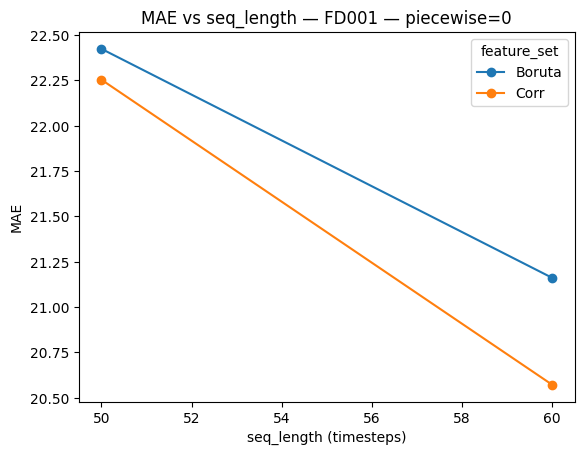

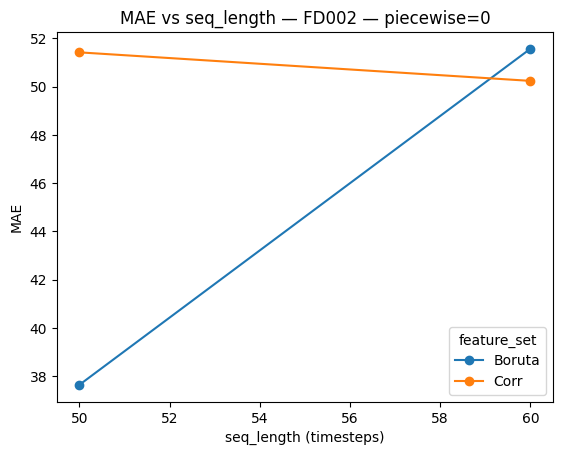

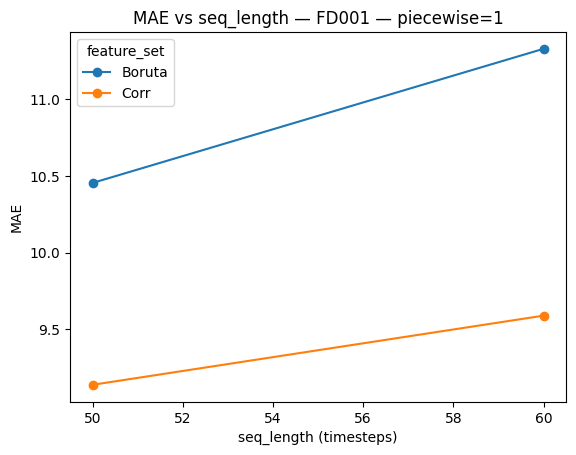

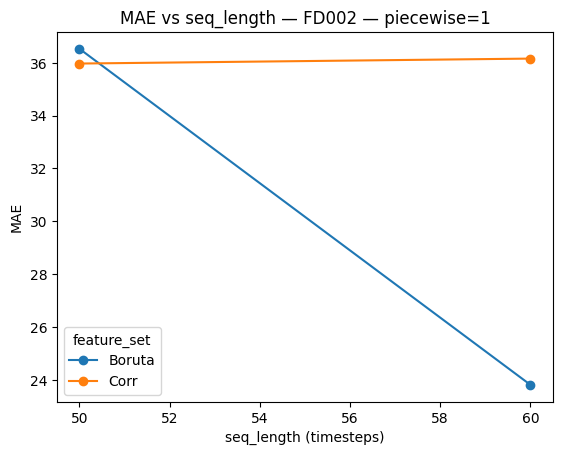

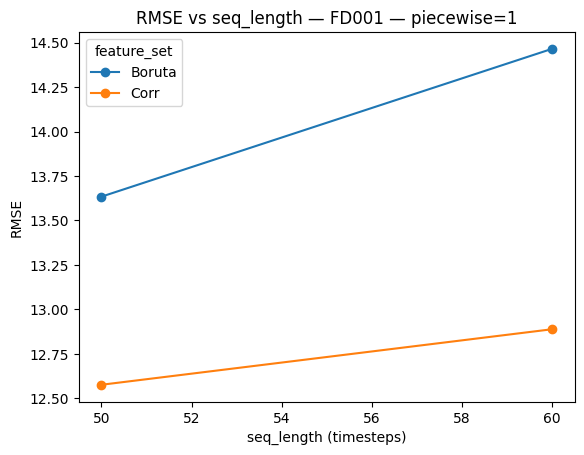

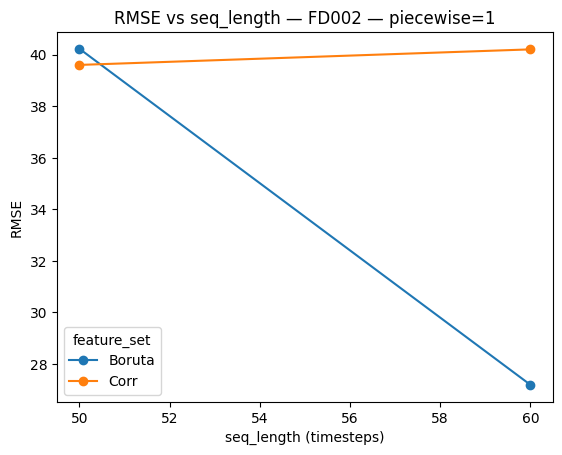

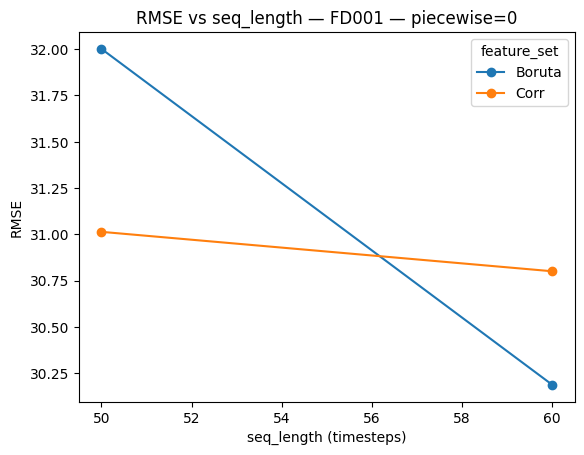

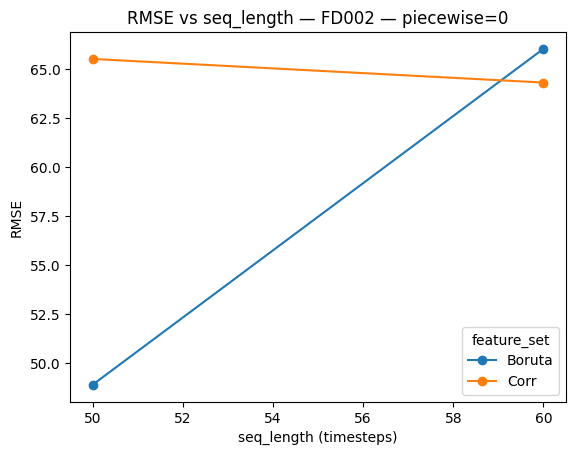

In [9]:
plot_trend_seq_length(df, metric="mae",  subset="FD001", piecewise=0)
plot_trend_seq_length(df, metric="mae",  subset="FD002", piecewise=0)
plot_trend_seq_length(df, metric="mae",  subset="FD001", piecewise=1)
plot_trend_seq_length(df, metric="mae",  subset="FD002", piecewise=1)
plot_trend_seq_length(df, metric="rmse", subset="FD001", piecewise=1)
plot_trend_seq_length(df, metric="rmse", subset="FD002", piecewise=1)
plot_trend_seq_length(df, metric="rmse", subset="FD001", piecewise=0)
plot_trend_seq_length(df, metric="rmse", subset="FD002", piecewise=0)

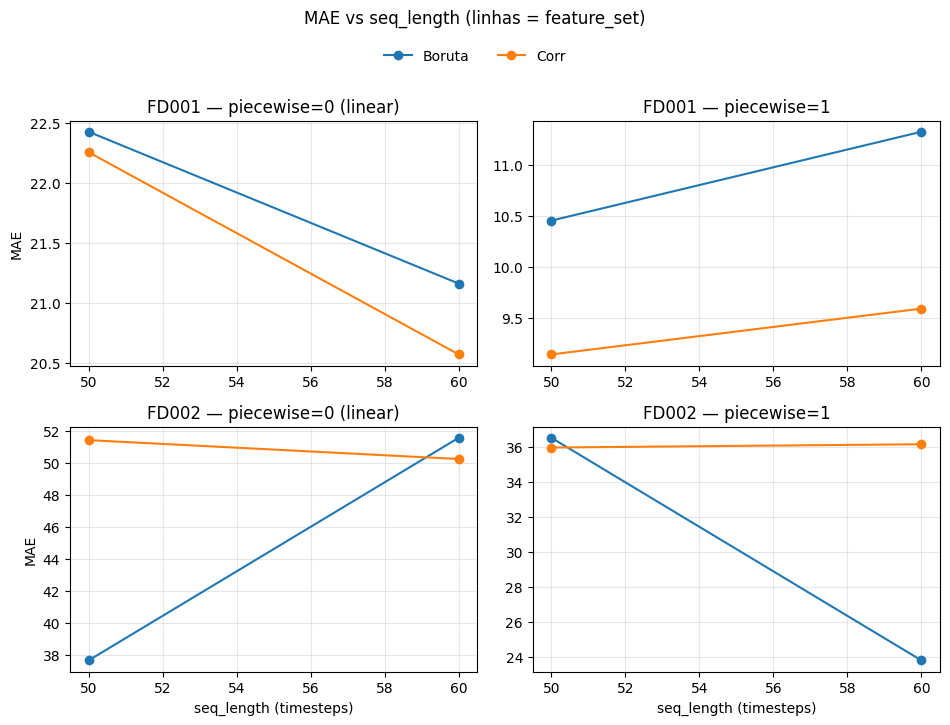

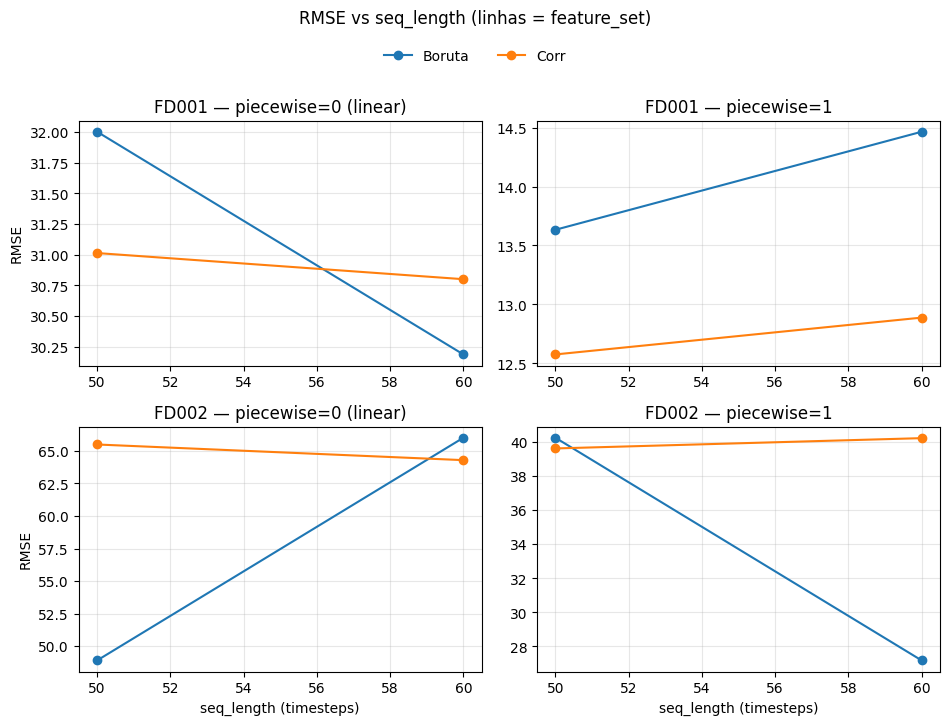

In [10]:
# --- Função única que faz a grelha (um gráfico por métrica) ---
def plot_trend_grid(data, metric="mae", feature_order=None, piecewise_order=(0,1), subsets=None):
    assert metric in ("mae","rmse"), "metric deve ser 'mae' ou 'rmse'"
    d = data.copy()
    if subsets is None:
        # ordem natural FD001, FD002, ...
        subsets = sorted(d["subset"].unique(), key=lambda s: (len(s), s))
    piecewise_order = [p for p in piecewise_order if p in d["piecewise_rul"].unique()]
    if feature_order is None:
        feature_order = sorted(d["feature_set"].astype(str).unique())

    nrows = len(subsets)
    ncols = len(piecewise_order) if piecewise_order else 1
    if nrows == 0 or ncols == 0:
        print("Sem dados para desenhar.")
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.8*ncols, 3.4*nrows), squeeze=False)
    lines_for_legend = []
    labels_for_legend = []

    for i, subset in enumerate(subsets):
        for j, pw in enumerate(piecewise_order):
            ax = axes[i][j]
            sub = d[(d["subset"]==subset) & (d["piecewise_rul"]==pw)]
            if sub.empty:
                ax.text(0.5, 0.5, "sem dados", ha="center", va="center")
                ax.set_axis_off()
                continue

            # média por seq_length e feature_set (caso tenhas réplicas)
            g = (sub.groupby(["seq_length","feature_set"], as_index=False)[metric]
                    .mean()
                    .sort_values(["feature_set","seq_length"]))

            # desenhar uma linha por feature_set na ordem pedida
            has_any = False
            for fs in feature_order:
                gi = g[g["feature_set"]==fs].sort_values("seq_length")
                if gi.empty:
                    continue
                ln, = ax.plot(gi["seq_length"], gi[metric], marker="o", label=str(fs))
                has_any = True
                # guardar uma vez para legenda global
                if str(fs) not in labels_for_legend:
                    labels_for_legend.append(str(fs))
                    lines_for_legend.append(ln)

            ax.set_title(f"{subset} — {'piecewise=1' if pw==1 else 'piecewise=0 (linear)'}")
            if j == 0:
                ax.set_ylabel(metric.upper())
            if i == nrows - 1:
                ax.set_xlabel("seq_length (timesteps)")
            ax.grid(True, alpha=0.3)
            if not has_any:
                ax.text(0.5, 0.5, "sem linhas", ha="center", va="center")
                ax.set_axis_off()

    # Legenda global no topo
    if lines_for_legend:
        fig.legend(lines_for_legend, labels_for_legend, loc="upper center", ncol=min(4, len(labels_for_legend)),
                   bbox_to_anchor=(0.5, 1.02), frameon=False)

    fig.suptitle(metric.upper() + " vs seq_length (linhas = feature_set)", y=1.06, fontsize=12)
    fig.tight_layout()
    plt.show()

# ======= Chamar apenas 2x: um para MAE e outro para RMSE =======
plot_trend_grid(df, metric="mae")   # 1º gráfico (todos os subsets × piecewise)
plot_trend_grid(df, metric="rmse")  # 2º gráfico

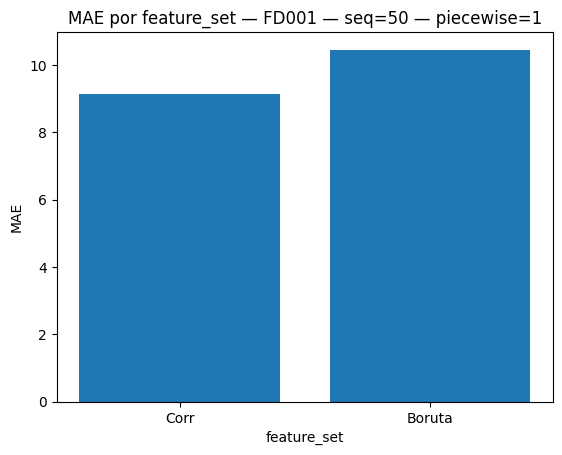

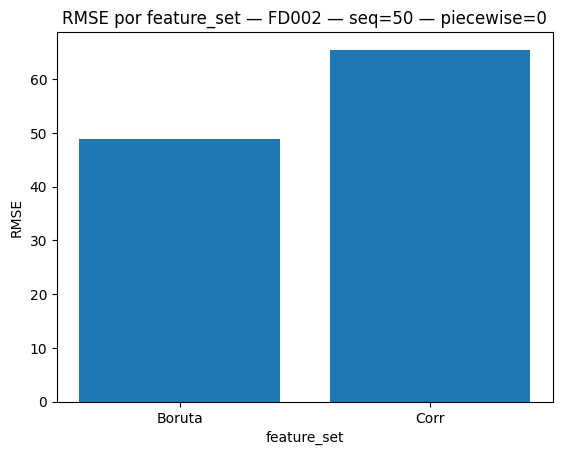

In [11]:
# =========================
# 3) Barras: impacto de feature_set (fixando subset, seq_length, piecewise)
# =========================
def plot_bar_features(data, metric="rmse", subset="FD001", seq_length=50, piecewise=0):
    d = data[
        (data["subset"]==subset) &
        (data["seq_length"]==int(seq_length)) &
        (data["piecewise_rul"]==int(piecewise))
    ].copy()
    if d.empty:
        print("Sem dados para", subset, f"seq={seq_length}", _piece_label(piecewise))
        return
    g = d.groupby("feature_set", as_index=False)[metric].mean().sort_values(metric)

    plt.figure()
    x = np.arange(len(g))
    plt.bar(x, g[metric].values)
    plt.xticks(x, g["feature_set"].tolist(), rotation=0)
    plt.title(f"{metric.upper()} por feature_set — {subset} — seq={seq_length} — {_piece_label(piecewise)}")
    plt.xlabel("feature_set")
    plt.ylabel(metric.upper())
    plt.show()

# Exemplo de uso:
plot_bar_features(df, metric="mae",  subset="FD001", seq_length=50, piecewise=1)
plot_bar_features(df, metric="rmse", subset="FD002", seq_length=50, piecewise=0)

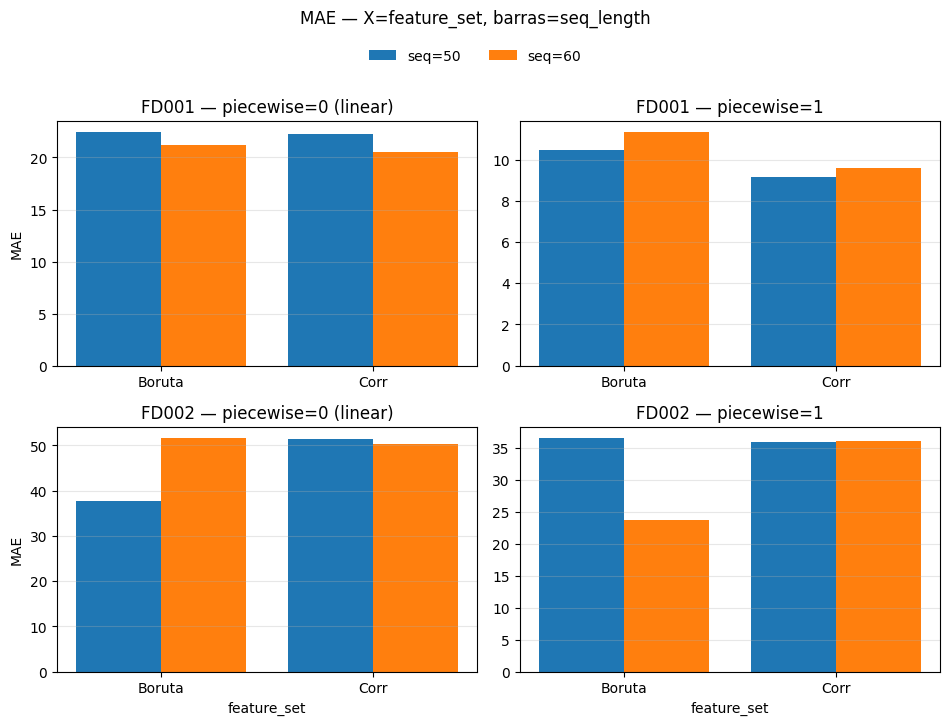

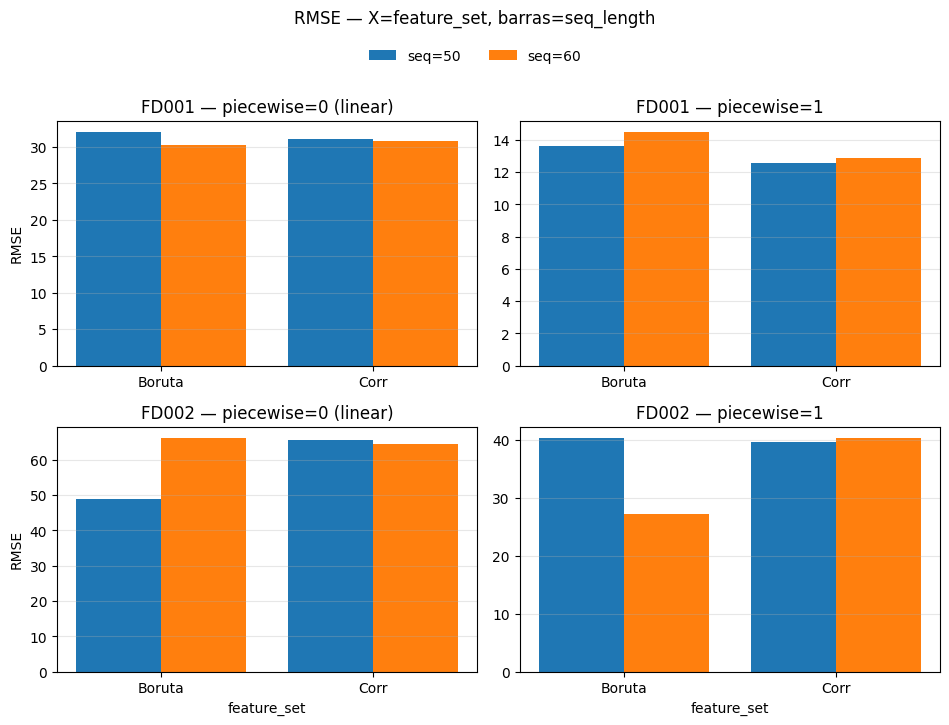

In [12]:
# Grelha: linhas=subsets, colunas=piecewise(0/1). Em cada painel:
# X = feature_set ; barras agrupadas por seq_length.
def plot_bar_grid(data, metric="mae", feature_order=None, seq_order=None, subsets=None, piecewise_order=None):
    assert metric in ("mae","rmse")
    d = data.copy()
    d["seq_length"] = d["seq_length"].astype(int)
    d["piecewise_rul"] = d["piecewise_rul"].astype(int)
    if subsets is None: subsets = _ordered_subsets(d)
    if piecewise_order is None: piecewise_order = _ordered_piecewise(d)
    if feature_order is None: feature_order = _ordered_features(d)
    if seq_order is None: seq_order = _ordered_seq(d)

    nrows, ncols = len(subsets), len(piecewise_order)
    if nrows == 0 or ncols == 0:
        print("Sem dados para desenhar.")
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.8*ncols, 3.4*nrows), squeeze=False)
    legend_handles = []
    legend_labels = []

    for i, subset in enumerate(subsets):
        for j, pw in enumerate(piecewise_order):
            ax = axes[i][j]
            sub = d[(d["subset"]==subset) & (d["piecewise_rul"]==pw)]
            if sub.empty:
                ax.text(0.5, 0.5, "sem dados", ha="center", va="center")
                ax.set_axis_off()
                continue

            # média por feature_set x seq_length
            g = (sub.groupby(["feature_set","seq_length"], as_index=False)[metric]
                    .mean())
            # pivot com linhas=feature_set (ordem fixa), colunas=seq_length (ordem fixa)
            pvt = pd.DataFrame(index=feature_order, columns=seq_order, dtype=float)
            for _, r in g.iterrows():
                if r["feature_set"] in pvt.index and r["seq_length"] in pvt.columns:
                    pvt.loc[r["feature_set"], r["seq_length"]] = r[metric]

            x = np.arange(len(feature_order))
            n_groups = len(seq_order) if len(seq_order)>0 else 1
            width = 0.8 / max(1, n_groups)

            has_any = False
            for k, sl in enumerate(seq_order):
                y = pvt[sl].values if sl in pvt.columns else np.full(len(feature_order), np.nan)
                if np.all(np.isnan(y)):
                    continue
                bars = ax.bar(x + (k - (n_groups-1)/2)*width, y, width=width, label=str(sl))
                has_any = True
                if str(sl) not in legend_labels:
                    legend_labels.append(str(sl))
                    legend_handles.append(bars)

            ax.set_title(f"{subset} — {'piecewise=1' if pw==1 else 'piecewise=0 (linear)'}")
            ax.set_xticks(x)
            ax.set_xticklabels(feature_order, rotation=0)
            if j == 0: ax.set_ylabel(metric.upper())
            if i == nrows - 1: ax.set_xlabel("feature_set")
            ax.grid(True, axis="y", alpha=0.3)
            if not has_any:
                ax.text(0.5, 0.5, "sem barras", ha="center", va="center")
                ax.set_axis_off()

    if legend_handles:
        fig.legend(legend_handles, [f"seq={lab}" for lab in legend_labels],
                   loc="upper center", ncol=min(6, len(legend_labels)),
                   bbox_to_anchor=(0.5, 1.02), frameon=False)
    fig.suptitle(metric.upper() + " — X=feature_set, barras=seq_length", y=1.06, fontsize=12)
    fig.tight_layout()
    plt.show()

# Chamada (gera só 2 gráficos):
plot_bar_grid(df, metric="mae")
plot_bar_grid(df, metric="rmse")

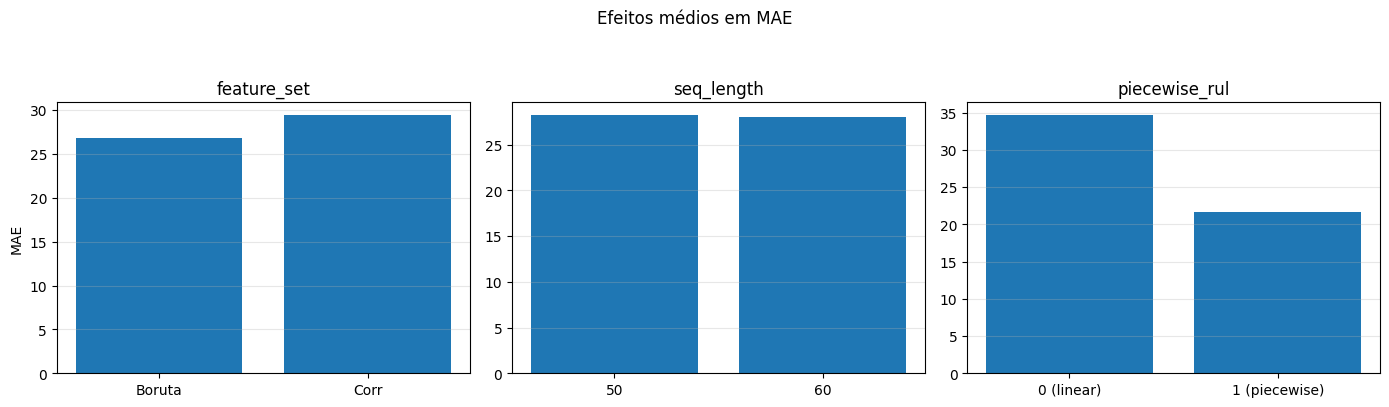

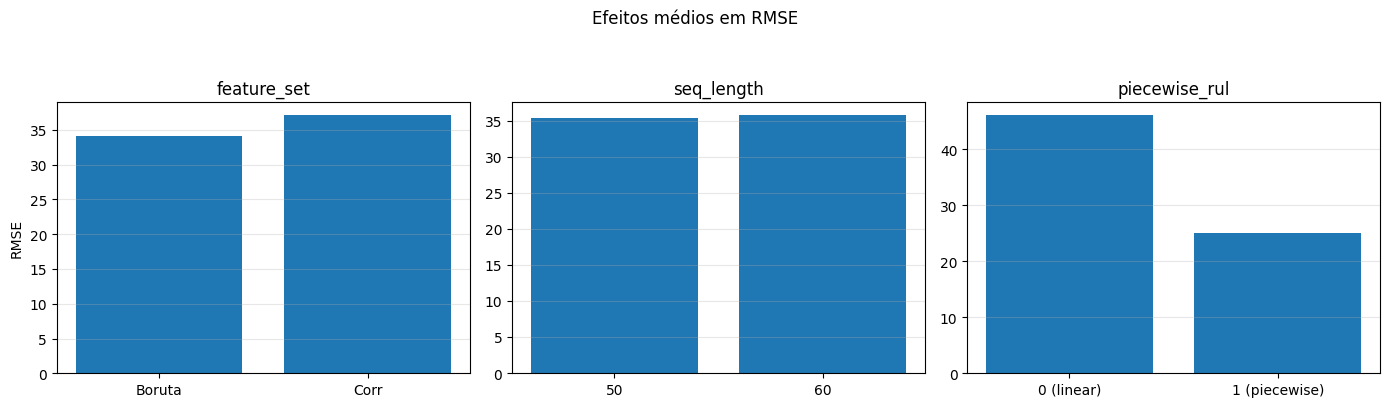

In [13]:
# =============== 3) EFEITOS MÉDIOS (um gráfico por métrica) ===========
# Uma figura com 3 subplots horizontais: feature_set, seq_length, piecewise_rul
def plot_main_effects(data, metric="mae", subsets=None):
    assert metric in ("mae","rmse")
    d = data.copy()
    if subsets is not None:
        d = d[d["subset"].isin(subsets)]
    if d.empty:
        print("Sem dados.")
        return

    # preparar ordens
    feature_order = _ordered_features(d)
    seq_order     = _ordered_seq(d)
    piece_order   = [0,1] if set([0,1]).intersection(set(d["piecewise_rul"])) else sorted(d["piecewise_rul"].unique())

    fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))
    fig.suptitle(f"Efeitos médios em {metric.upper()}", fontsize=12, y=1.06)

    # 1) feature_set
    g1 = d.groupby("feature_set", as_index=False)[metric].mean()
    g1 = g1.set_index("feature_set").reindex(feature_order).reset_index()
    ax = axes[0]
    x = np.arange(len(g1))
    ax.bar(x, g1[metric].values)
    ax.set_xticks(x); ax.set_xticklabels(g1["feature_set"].astype(str).tolist(), rotation=0)
    ax.set_title("feature_set"); ax.set_ylabel(metric.upper()); ax.grid(True, axis="y", alpha=0.3)

    # 2) seq_length
    g2 = d.groupby("seq_length", as_index=False)[metric].mean()
    g2 = g2.set_index("seq_length").reindex(seq_order).reset_index()
    ax = axes[1]
    x = np.arange(len(g2))
    ax.bar(x, g2[metric].values)
    ax.set_xticks(x); ax.set_xticklabels(g2["seq_length"].astype(str).tolist(), rotation=0)
    ax.set_title("seq_length"); ax.grid(True, axis="y", alpha=0.3)

    # 3) piecewise_rul
    g3 = d.groupby("piecewise_rul", as_index=False)[metric].mean()
    g3 = g3.set_index("piecewise_rul").reindex(piece_order).reset_index()
    ax = axes[2]
    x = np.arange(len(g3))
    ax.bar(x, g3[metric].values)
    lbls = ["0 (linear)","1 (piecewise)"] if piece_order==[0,1] else [str(v) for v in piece_order]
    ax.set_xticks(x); ax.set_xticklabels(lbls, rotation=0)
    ax.set_title("piecewise_rul"); ax.grid(True, axis="y", alpha=0.3)

    fig.tight_layout()
    plt.show()

# Chamada (gera só 2 gráficos):
plot_main_effects(df, metric="mae")
plot_main_effects(df, metric="rmse")

In [14]:
# paleta consistente por feature_set
def _feature_colors(d):
    feats = _ordered_features(d)
    base = plt.rcParams['axes.prop_cycle'].by_key()['color']
    col = {}
    for i, f in enumerate(feats):
        col[f] = base[i % len(base)]
    return col

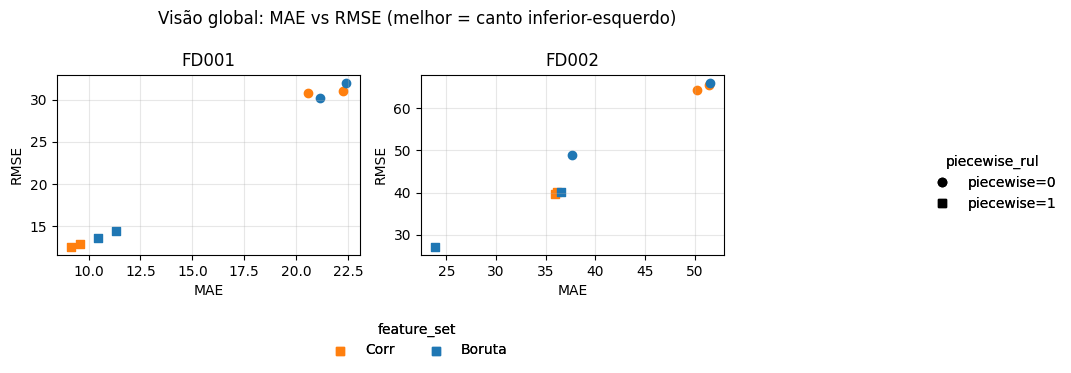

In [15]:
# =========================
# FIGURA 3 — Dispersão global MAE vs RMSE
# painéis por subset; cor=feature_set; marcador=piecewise (o=linear, s=piecewise)
# =========================
def plot_overview_scatter(data):
    d = data.copy()
    if d.empty:
        print("Sem dados."); return

    # ordens/utilitários
    def _ordered_subsets(dd):  return sorted(dd["subset"].unique(), key=lambda s: (len(s), s))
    def _ordered_features(dd): return sorted(dd["feature_set"].astype(str).unique())
    def _feature_colors(dd):
        feats = _ordered_features(dd)
        base = plt.rcParams['axes.prop_cycle'].by_key()['color']
        return {f: base[i % len(base)] for i, f in enumerate(feats)}

    subsets = _ordered_subsets(d)
    feats   = _ordered_features(d)
    colors  = _feature_colors(d)
    markers = {0: "o", 1: "s"}  # 0=linear, 1=piecewise

    n = len(subsets)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.8*ncols, 3.6*nrows), squeeze=False)

    # colecionar handles para legendas
    feat_handles = {}
    for idx, subset in enumerate(subsets):
        i, j = divmod(idx, ncols)
        ax = axes[i][j]
        sub = d[d["subset"]==subset]
        if sub.empty:
            ax.text(0.5, 0.5, "sem dados", ha="center", va="center"); ax.set_axis_off(); continue

        for _, r in sub.iterrows():
            m = markers.get(int(r["piecewise_rul"]), "o")
            c = colors[r["feature_set"]]
            pt = ax.scatter(r["mae"], r["rmse"], marker=m, c=c)
            # guardar um handle por feature_set (para a legenda de cores)
            if r["feature_set"] not in feat_handles:
                feat_handles[r["feature_set"]] = pt

        ax.set_title(subset)
        ax.set_xlabel("MAE")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)

    # desligar eixos vazios se existirem
    for k in range(n, nrows*ncols):
        i, j = divmod(k, ncols)
        axes[i][j].set_axis_off()

    # ---- Legendas sem sobreposição ----
    # 1) legenda de cores (feature_set) em baixo, centrada
    if feat_handles:
        feat_labels  = list(feat_handles.keys())
        feat_handles = [feat_handles[k] for k in feat_labels]
        leg_features = fig.legend(
            feat_handles, feat_labels,
            loc="lower center", bbox_to_anchor=(0.5, -0.02),
            ncol=min(6, len(feat_labels)), frameon=False, title="feature_set"
        )
        fig.add_artist(leg_features)

    # 2) legenda dos marcadores (piecewise_rul) à direita, fora da grelha
    pw_handles = [
        Line2D([0],[0], marker="o", linestyle="none", markerfacecolor="black", markeredgecolor="black", label="piecewise=0"),
        Line2D([0],[0], marker="s", linestyle="none", markerfacecolor="black", markeredgecolor="black", label="piecewise=1"),
    ]
    leg_piece = fig.legend(
        handles=pw_handles, loc="center left",
        bbox_to_anchor=(1.02, 0.5), frameon=False, title="piecewise_rul"
    )
    fig.add_artist(leg_piece)

    # espaço para as legendas (topo/baixo/direita)
    fig.suptitle("Visão global: MAE vs RMSE (melhor = canto inferior-esquerdo)", y=0.98, fontsize=12)
    fig.subplots_adjust(top=0.8, bottom=0.30, right=0.82)  # aumenta se ainda recortar
    plt.show()

# =========================
# Como usar (gera só 3 figuras essenciais)
# =========================
# plot_trend_grid_minimal(df)         # FIGURA 1 (RMSE vs seq_length)
# plot_feature_impact_bars_minimal(df) # FIGURA 2 (impacto de feature_set no RMSE)
plot_overview_scatter(df)            # FIGURA 3 (MAE vs RMSE por subset)

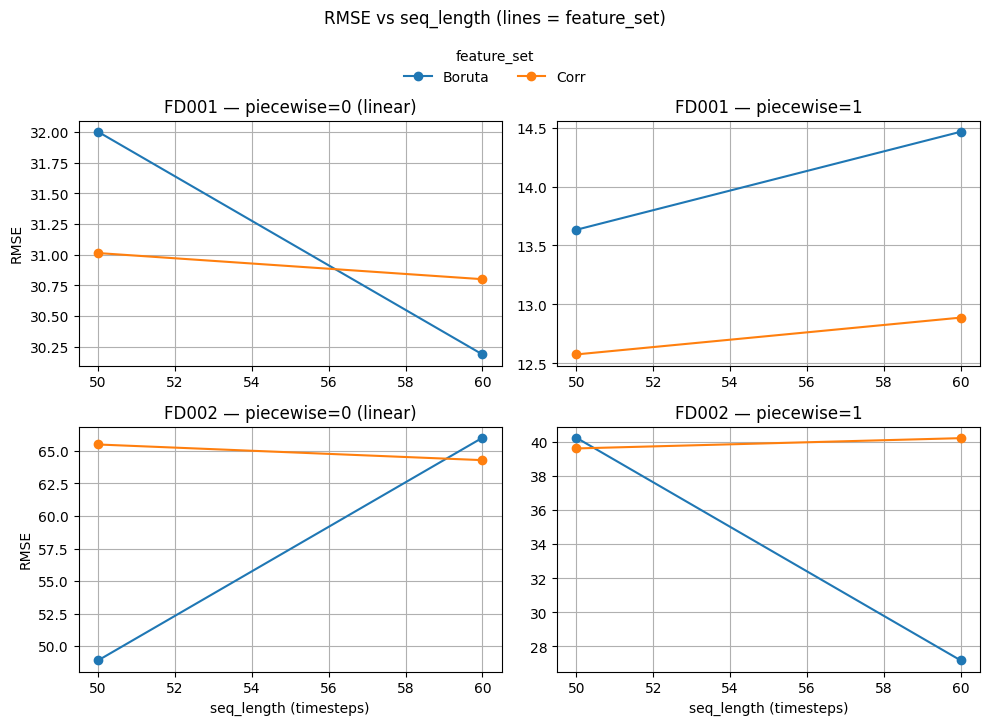

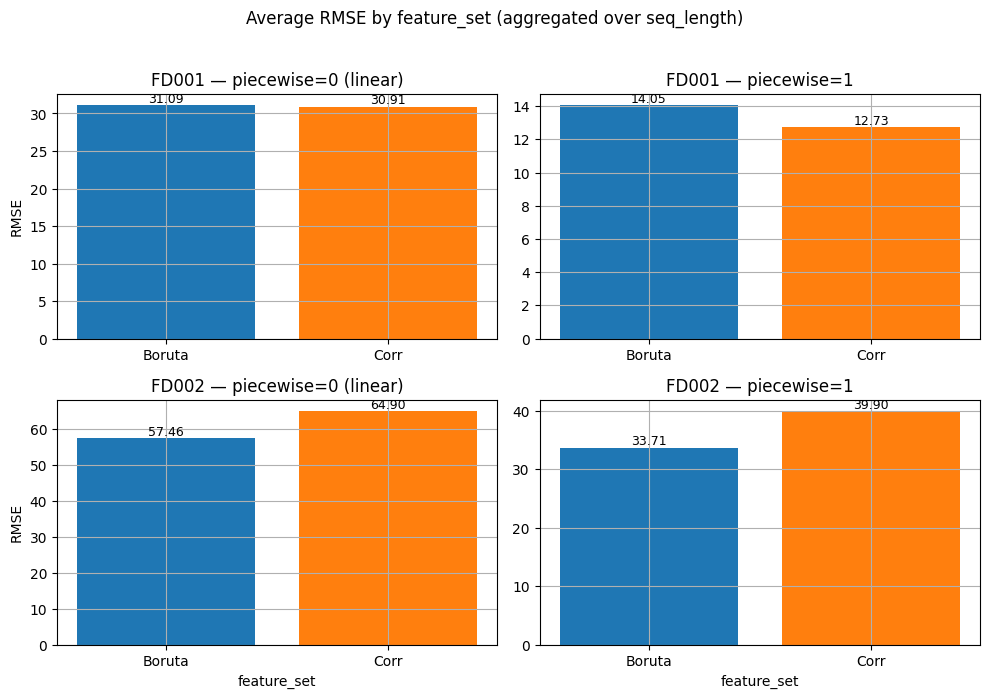

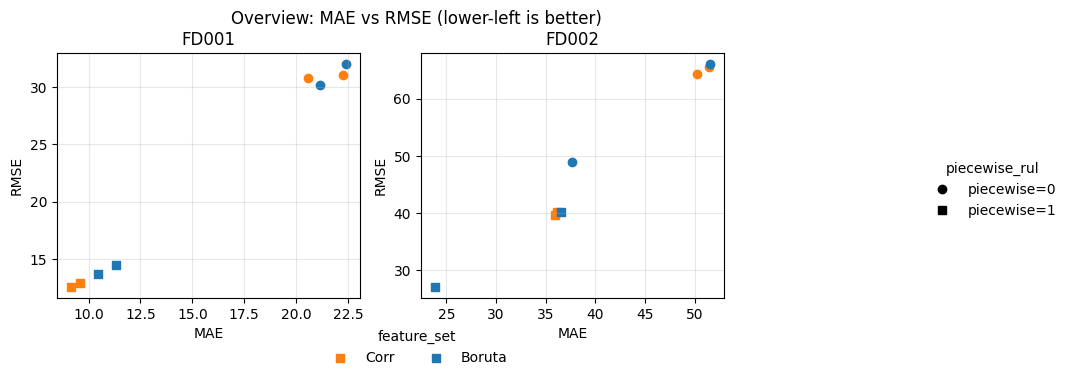

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# =============================
# 1) Put your results here
# =============================
# rows = [
#     ("FD001", 30, 0, "All",    24.10, 33.00),
#     ("FD001", 50, 0, "Corr",   22.59, 31.42),
#     ("FD001", 50, 1, "Corr",   21.30, 29.70),
#     ("FD001", 50, 1, "Boruta", 20.95, 29.10),
#     ("FD002", 50, 0, "Corr",   51.58, 65.71),
#     ("FD002", 50, 1, "Corr",   49.90, 63.50),
#     # add more lines (FD003/FD004, other seq_length, etc.)
# ]
# df = pd.DataFrame(rows, columns=["subset","seq_length","piecewise_rul","feature_set","mae","rmse"])

# If you already have df, keep only this casting:
# df = df.copy()
df["seq_length"] = df["seq_length"].astype(int)
df["piecewise_rul"] = df["piecewise_rul"].astype(int)
df["feature_set"] = df["feature_set"].astype(str)

plt.rcParams.update({"figure.figsize": (6, 4), "axes.grid": True})

# small helpers to keep consistent order
subsets = sorted(df["subset"].unique(), key=lambda s: (len(s), s))
piecewise_vals = [x for x in [0, 1] if x in df["piecewise_rul"].unique()]
feature_sets = sorted(df["feature_set"].unique())
# simple color map for feature_set
base_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
feat_color = {f: base_colors[i % len(base_colors)] for i, f in enumerate(feature_sets)}

# =========================================================
# FIGURE 1 — RMSE vs seq_length (lines = feature_set)
# panels = subset × piecewise_rul
# =========================================================
rows = len(subsets)
cols = len(piecewise_vals)
if rows == 0 or cols == 0:
    print("No data to plot Figure 1.")
else:
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.4*rows))
    axes = np.atleast_2d(axes)
    legend_handles = {}

    for i, sb in enumerate(subsets):
        for j, pw in enumerate(piecewise_vals):
            ax = axes[i, j]
            d = df[(df["subset"] == sb) & (df["piecewise_rul"] == pw)]
            if d.empty:
                ax.axis("off")
                ax.text(0.5, 0.5, "no data", ha="center")
                continue

            g = d.groupby(["seq_length","feature_set"])["rmse"].mean().reset_index()
            for fs in feature_sets:
                gi = g[g["feature_set"] == fs].sort_values("seq_length")
                if gi.empty:
                    continue
                line, = ax.plot(gi["seq_length"], gi["rmse"], marker="o", label=fs, color=feat_color[fs])
                if fs not in legend_handles:
                    legend_handles[fs] = line

            ax.set_title(f"{sb} — {'piecewise=1' if pw==1 else 'piecewise=0 (linear)'}")
            if j == 0:
                ax.set_ylabel("RMSE")
            if i == rows - 1:
                ax.set_xlabel("seq_length (timesteps)")

    if legend_handles:
        fig.legend(list(legend_handles.values()), list(legend_handles.keys()),
                   loc="upper center", ncol=min(5, len(legend_handles)),
                   bbox_to_anchor=(0.5, 1.02), frameon=False, title="feature_set")
    fig.suptitle("RMSE vs seq_length (lines = feature_set)", y=1.06, fontsize=12)
    fig.tight_layout()
    plt.show()

# =========================================================
# FIGURE 2 — Bars: average RMSE by feature_set
# panels = subset × piecewise_rul
# =========================================================
rows = len(subsets)
cols = len(piecewise_vals)
if rows == 0 or cols == 0:
    print("No data to plot Figure 2.")
else:
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.4*rows))
    axes = np.atleast_2d(axes)

    for i, sb in enumerate(subsets):
        for j, pw in enumerate(piecewise_vals):
            ax = axes[i, j]
            d = df[(df["subset"] == sb) & (df["piecewise_rul"] == pw)]
            if d.empty:
                ax.axis("off")
                ax.text(0.5, 0.5, "no data", ha="center")
                continue

            g = d.groupby("feature_set")["rmse"].mean().reindex(feature_sets)
            x = np.arange(len(feature_sets))
            y = g.values
            ax.bar(x, y, color=[feat_color[f] for f in feature_sets])
            ax.set_xticks(x)
            ax.set_xticklabels(feature_sets, rotation=0)
            ax.set_title(f"{sb} — {'piecewise=1' if pw==1 else 'piecewise=0 (linear)'}")
            if j == 0:
                ax.set_ylabel("RMSE")
            if i == rows - 1:
                ax.set_xlabel("feature_set")

            # show value on top of each bar
            for xi, yi in zip(x, y):
                if not np.isnan(yi):
                    ax.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom", fontsize=9)

    fig.suptitle("Average RMSE by feature_set (aggregated over seq_length)", y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

# =========================================================
# FIGURE 3 — Overview: MAE vs RMSE
# panels by subset; color = feature_set; marker: circle=linear(0), square=piecewise(1)
# legends placed to avoid overlap
# =========================================================
subs = subsets
n = len(subs)
if n == 0:
    print("No data to plot Figure 3.")
else:
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.8*ncols, 3.6*nrows))
    axes = np.atleast_2d(axes)

    marker_map = {0: "o", 1: "s"}
    feat_handles = {}
    pw_handles = {
        "piecewise=0": Line2D([0],[0], marker="o", linestyle="none", markerfacecolor="black", markeredgecolor="black"),
        "piecewise=1": Line2D([0],[0], marker="s", linestyle="none", markerfacecolor="black", markeredgecolor="black"),
    }

    for idx, sb in enumerate(subs):
        i, j = divmod(idx, ncols)
        ax = axes[i, j]
        d = df[df["subset"] == sb]
        if d.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, "no data", ha="center")
            continue

        for _, r in d.iterrows():
            c = feat_color[r["feature_set"]]
            m = marker_map.get(int(r["piecewise_rul"]), "o")
            p = ax.scatter(r["mae"], r["rmse"], c=c, marker=m)
            if r["feature_set"] not in feat_handles:
                feat_handles[r["feature_set"]] = p

        ax.set_title(sb)
        ax.set_xlabel("MAE")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)

    # turn off any empty subplot
    for k in range(n, nrows*ncols):
        i, j = divmod(k, ncols)
        axes[i, j].set_axis_off()

    # legends outside to avoid overlap
    if feat_handles:
        fig.legend(list(feat_handles.values()), list(feat_handles.keys()),
                   loc="lower center", bbox_to_anchor=(0.5, -0.02),
                   ncol=min(6, len(feat_handles)), frameon=False, title="feature_set")
    fig.legend(list(pw_handles.values()), list(pw_handles.keys()),
               loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, title="piecewise_rul")

    fig.suptitle("Overview: MAE vs RMSE (lower-left is better)", y=1, fontsize=12)
    fig.subplots_adjust( bottom=0.20, right=0.82)
    plt.show()


# Final


## Boiler plate initial code

In [17]:
df["seq_length"] = df["seq_length"].astype(int)
df["piecewise_rul"] = df["piecewise_rul"].astype(int)
df["feature_set"] = df["feature_set"].astype(str)

plt.rcParams.update({"figure.figsize": (6, 4), "axes.grid": True})

# small helpers to keep consistent order
subsets = sorted(df["subset"].unique(), key=lambda s: (len(s), s))
piecewise_vals = [x for x in [0, 1] if x in df["piecewise_rul"].unique()]
feature_sets = sorted(df["feature_set"].unique())
# simple color map for feature_set
base_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
feat_color = {f: base_colors[i % len(base_colors)] for i, f in enumerate(feature_sets)}

## Dotted plot
Plot to show the MAE and RMSE values depending on the sequence length ordered by piece wise, feature set.


In [18]:
print("Starting plot for dot values of RMSE and MAE")
rows = len(subsets)
print(rows)
print(subsets)

print(piecewise_vals)

Starting plot for dot values of RMSE and MAE
2
['FD001', 'FD002']
[0, 1]


In [19]:
print("Starting plot for dot values of RMSE and MAE")
rows = len(subsets)

def plot_trend_grid(group_information_value):
  cols = len(piecewise_vals)
  if rows == 0 or cols == 0:
      print("No data to plot Figure 1.")
  else:
      fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
      axes = np.atleast_2d(axes)
      legend_handles = {}

      for i, subset in enumerate(subsets):
          for j, piecewise in enumerate(piecewise_vals):
              ax = axes[i, j]
              data = df[(df["subset"] == subset) & (df["piecewise_rul"] == piecewise)]
              if data.empty:
                  ax.axis("off")
                  #ax.text(0.5, 0.5, "no data", ha="center")
                  continue

              grouped = data.groupby(["seq_length","feature_set"])[group_information_value].mean().reset_index()
              for feature_set in feature_sets:
                  group_information = grouped[grouped["feature_set"] == feature_set].sort_values("seq_length")
                  if group_information.empty:
                      continue
                  line, = ax.plot(group_information["seq_length"], group_information[group_information_value], marker="o", label=feature_set, color=feat_color[feature_set])
                  if feature_set not in legend_handles:
                      legend_handles[feature_set] = line

              ax.set_title(f"{subset} — {'piecewise=1' if piecewise==1 else 'piecewise=0 (linear)'}")
              if j == 0:
                if group_information_value == "rmse":
                  ax.set_ylabel("RMSE")
                  fig.suptitle("RMSE vs seq_length", y=1.06, fontsize=12)
                else:
                  ax.set_ylabel("MAE")
                  fig.suptitle("MAE vs seq_length", y=1.06, fontsize=12)
              if i == rows - 1:
                  ax.set_xlabel("seq_length (timesteps)")

      if legend_handles:
          fig.legend(list(legend_handles.values()), list(legend_handles.keys()),
                    loc="upper center", ncol=min(5, len(legend_handles)),
                    bbox_to_anchor=(0.5, 1.02), frameon=False, title="feature_set")

      fig.tight_layout()
      plt.show()

Starting plot for dot values of RMSE and MAE


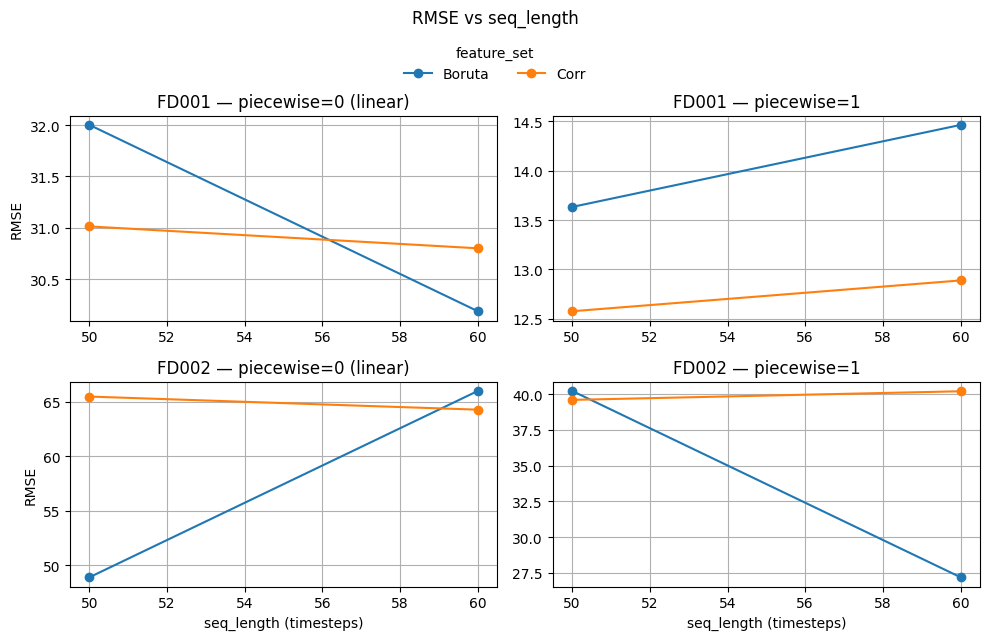

In [20]:
plot_trend_grid("rmse")

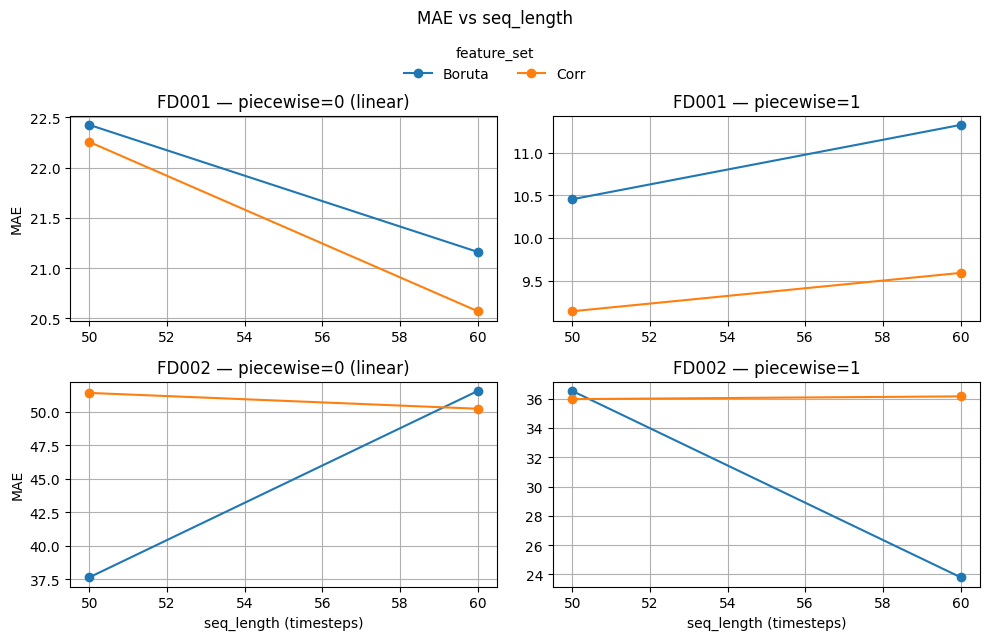

In [21]:
plot_trend_grid("mae")